# Terraclim climate preprocessing

## Preprocesses Terraclim climate data from 2000-2024

- scales values to get real life units (e.g. mm, C) 
- clips to AOI
- creates monthly composite
- exports as tifs

## Setup

In [1]:
# GEE Authentication

# do this separately before anything else because you don't want to have to rerun this 
# every time you need to install something new - pain in the ass

# Install Earth Engine API
!pip install -q earthengine-api 

# import ee
import ee
# from ee.oauth import get_credentials_path
# print(get_credentials_path())

# Authenticate Earth Engine
ee.Authenticate(force=True)
print('GEE authenticated')

Enter verification code:  4/1ATX87lPN2ZhHx8coPJPwd6iuAGDWobh_q8-DX8XAyTt0vcpg3XaqGEM6opw



Successfully saved authorization token.
GEE authenticated


In [5]:
# Initialize Earth Engine
ee.Initialize(project='columbia-phd')
print('GEE initialized')

# import whatever else you need
from datetime import datetime
import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap
!pip install -q geemap # GEEmap for visualization
# !pip install -q ipywidgets geemap
# !pip install -q ipywidgets geemap jupyterlab_widgets
import geemap
print('GEE imported')

# load in data
# --------------------------------------------------------------------------------------------
# --------------------------------------------------------------------------------------------

# AOI
# --------------------------

# FAO Madre de dios Border
# faoFC = ee.FeatureCollection("FAO/GAUL/2015/level2")
# aoiFC = faoFC.filter(ee.Filter.eq('ADM1_NAME', 'Madre de Dios'))
# print(aoiFC)

# manually create bounding box
square = ee.Feature(
    ee.Geometry.Polygon([
        [[-73.489604265885, -9.106738678620076],
          [-73.489604265885, -14.471148538041154],
          [-67.72178200026, -14.471148538041154],
          [-67.72178200026, -9.106738678620076]]
    ])
)

# convert to a feature collection
aoiFC = ee.FeatureCollection([square])

# Terraclim
# --------------------------

# https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
terraClimIC = (
    ee.ImageCollection('IDAHO_EPSCOR/TERRACLIMATE')
    .filter(ee.Filter.date('2000-01-01', '2024-12-31'))
    .select(['tmmx', 'tmmn', 'pr','pdsi','def','vpd','soil'])
    .map(lambda img: img.clip(aoiFC))
)

# extract the resolution for later
res = terraClimIC.first().projection().nominalScale().getInfo()

# print some stuff to check
print('pixel size:', res) # pixel size
print('band names:', terraClimIC.first().bandNames().getInfo()) # band names

GEE initialized
GEE imported
pixel size: 4638.312116386398
band names: ['tmmx', 'tmmn', 'pr', 'pdsi', 'def', 'vpd', 'soil']


## Scale Values

In [11]:
# scale
# --------------------------

# scale values according to Terraclim metadata
#not sure why they store the data this way but the raw values aren't in real life units

# define scaling factors for each band
scales = {
    'tmmx': 0.1,
    'tmmn': 0.1,
    'pr': 1,
    'pdsi': 0.01,
    'def': 0.1,
    'vpd': 0.01,
    'soil': 0.1
}

# define a function that scales each band in an image
def scale_bands(img):
    
    # Multiply each band by its scale value from the dictionary
    scaled = img.select(list(scales.keys())) \
                .multiply(ee.Image.constant(list(scales.values())))
    
    # Preserve band names
    scaled = scaled.rename(list(scales.keys()))

    # return the new image with the scales values
    return scaled.copyProperties(img, img.propertyNames())

# Apply to the collection
terraClimIC_scaled = terraClimIC.map(scale_bands)

# get min/max
# --------------------------

# get min and max values for visualization + checking 

# get the average value for the entire time period at each pixel (can use either mean or median)
terraClim_mean = terraClimIC_scaled.median()
# get the min and max value for the entire region
minMaxStats = terraClim_mean.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=aoiFC,          
    scale=res,              
    maxPixels=1e13
)

# print
print(minMaxStats.getInfo()) # entire min/max dictionary
print('min/max of max temp', minMaxStats.get('tmmx_min').getInfo(), '/', minMaxStats.get('tmmx_max').getInfo()) 
print('min/max of vpd', minMaxStats.get('vpd_min').getInfo(), '/', minMaxStats.get('vpd_max').getInfo()) 
print('min/max of precip', minMaxStats.get('pr_min').getInfo(), '/', minMaxStats.get('pr_max').getInfo())

{'def_max': 73.99000000000001, 'def_min': 0, 'pdsi_max': 2.2814285714285716, 'pdsi_min': -3.276666666666667, 'pr_max': 440.75, 'pr_min': 23, 'soil_max': 349.43333333333334, 'soil_min': 4.11, 'tmmn_max': 21.800000000000008, 'tmmn_min': -7.75, 'tmmx_max': 31.600000000000005, 'tmmx_min': 8.4, 'vpd_max': 1.18, 'vpd_min': 0.4100000000000001}
min/max of max temp 8.4 / 31.600000000000005
min/max of vpd 0.4100000000000001 / 1.18
min/max of precip 23 / 440.75


## Visualize

In [12]:
# Create map
m = geemap.Map()
# center map on AOI
m.centerObject(aoiFC, zoom=7)

# define visualization parameters
palette = [
        '1a3678', '2955bc', '5699ff', '8dbae9', 'acd1ff', 'caebff', 'e5f9ff',
        'fdffb4', 'ffe6a2', 'ffc969', 'ffa12d', 'ff7c1f', 'ca531a', 'ff0000',
        'ab0000'
    ]

# add layers to map
m.addLayer(aoiFC, {}, "AOI")
m.addLayer(terraClim_mean.select('tmmx'), 
           {'min': minMaxStats.get('tmmx_min'),
            'max': minMaxStats.get('tmmx_max'),
            'palette':palette}, 
           "Avg Max temp")
m.addLayer(terraClim_mean.select('tmmn'), 
           {'min': minMaxStats.get('tmmn_min'),
            'max': minMaxStats.get('tmmn_max'),
            'palette':palette}, 
           "Avg Min temp")
m.addLayer(terraClim_mean.select('pdsi'), 
           {'min': minMaxStats.get('pdsi_min'),
            'max': minMaxStats.get('pdsi_max'),
            'palette':palette}, 
           "Avg PDSI")
m.addLayer(terraClim_mean.select('vpd'), 
           {'min': minMaxStats.get('vpd_min'),
            'max': minMaxStats.get('vpd_max'),
            'palette':palette}, 
           "Avg VPD")
m.addLayer(terraClim_mean.select('def'), 
           {'min': minMaxStats.get('def_min'),
            'max': minMaxStats.get('def_max'),
            'palette':palette}, 
           "Avg Water deficit")
m.addLayer(terraClim_mean.select('pr'), 
           {'min': minMaxStats.get('pr_min'),
            'max': minMaxStats.get('pr_max'),
            'palette':palette}, 
           "Precip")
m.addLayer(terraClim_mean.select('soil'), 
           {'min': minMaxStats.get('soil_min'),
            'max': minMaxStats.get('soil_max'),
            'palette':palette}, 
           "Avg Soil moisture")

# print map
m

Map(center=[-11.794669076434946, -70.60569313307249], controls=(WidgetControl(options=['position', 'transparen…

## Monthly Composite

In [15]:
# make sure the monthly composites are ready to use for our model

# check number of images
# print("Images in 2010:", terraClimIC_scaled.filterDate('2010-01-01', '2010-12-31').size().getInfo())
print("Image total:", terraClimIC_scaled.size().getInfo())

# create a list of years to iterate through
years = ee.List.sequence(2000, 2024)

# define a function that counts how many images per year
def count_by_year(y):
    
    # make sure year is recognized as a number object
    y = ee.Number(y)

    # extract Terraclim images from that year
    fc = terraClimIC_scaled.filterDate(
        ee.Date.fromYMD(y, 1, 1),
        ee.Date.fromYMD(y.add(1), 1, 1)
    )
    
    # return year and count as a feature
    return ee.Feature(None, {
        'year': y,
        'count': fc.size()
    })

# apply the function to the list of years
yrCounts = ee.FeatureCollection(years.map(count_by_year))

# print
yrCounts_simple = yrCounts.aggregate_array('year').zip(
    yrCounts.aggregate_array('count')
).getInfo()
for yr, cnt in yrCounts_simple:
    print(yr, cnt)

Images in 2010: 12
Image total: 300
2000 12
2001 12
2002 12
2003 12
2004 12
2005 12
2006 12
2007 12
2008 12
2009 12
2010 12
2011 12
2012 12
2013 12
2014 12
2015 12
2016 12
2017 12
2018 12
2019 12
2020 12
2021 12
2022 12
2023 12
2024 12


## Export

In [27]:
# export

# define export folder
export_folder = "/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim"
# define image collection to export
collection = terraClimIC_scaled

# Create a list of images from the image collection so we can iterate through it
ee_list = collection.toList(collection.size())

# iterate through the list of images
for i in range(collection.size().getInfo()):

    # extract the image from the list
    image = ee.Image(ee_list.get(i))

    # extract the date
    timeStart = image.get('system:time_start').getInfo()
    timeStart_date = datetime.utcfromtimestamp(timeStart / 1000)
    # create a year-month string from the date
    timeStart_str = timeStart_date.strftime('%Y_%m')

    # create a full output path with the folder and name 
    out_path = os.path.join(export_folder, f"terraClim_{timeStart_str}.tif")

    # export image to the folder
    geemap.ee_export_image(
        image,
        filename=out_path,
        region=aoiFC.geometry(),
        scale=res,
    )

    print(f"Exported {out_path}")

Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_01.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_02.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_02.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_03.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_03.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_04.tif
Exported /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_04.tif
Generating URL ...
Please wait ...
Data downloaded to /home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2000_05.tif
E

Band count: 7


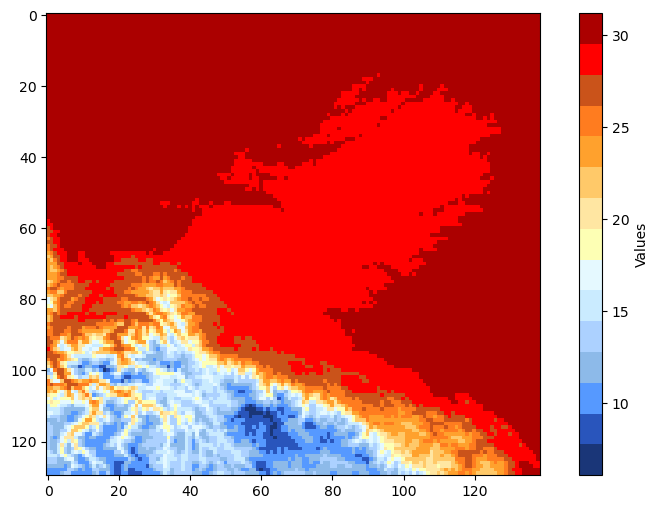

Map(center=[-11.794669076434946, -70.60569313307249], controls=(WidgetControl(options=['position', 'transparen…

In [30]:
# the check export

# visualize tif
# --------------------------

# visualize tif you just exported

# Open raster 
with rasterio.open("/home/jovyan/MLEAEEE4000-DroughtAmazon2/data/TerraClim/terraClim_2001_03.tif") as src:
    raster = src.read(1)          # read first band
    # print some stuff
    print("Band count:", src.count) 
    # print("Band descriptions:", src.descriptions)
    # print("Metadata:", src.meta)
    # print("CRS:", src.crs)

# Define color palette
palette = [
    '#1a3678', '#2955bc', '#5699ff', '#8dbae9', '#acd1ff', '#caebff', '#e5f9ff',
    '#fdffb4', '#ffe6a2', '#ffc969', '#ffa12d', '#ff7c1f', '#ca531a', '#ff0000',
    '#ab0000'
]

# Visualize
plt.figure(figsize=(10, 6))
plt.imshow(raster, cmap=ListedColormap(palette))
plt.colorbar(label='Values')
plt.show()

# compare to GEE
# --------------------------

# compare to the GEE image collection from the same time step

# create map
m = geemap.Map()
# center map
m.centerObject(aoiFC, zoom=7)

# add TerraClim data from same time step and same band
m.addLayer(terraClimIC_scaled
    .filter(ee.Filter.date('2001-03-01', '2001-03-31'))
    .select('tmmx')
    .first(), 
           {'min': 10,
            'max': 30,
            'palette':palette}, 
           "Max temp")

# plot
m